# Евклидова задача коммивояжёра
### Начинкин Илья, 695

Нужно построить приближенный алгоритм решения euclidean TSP - поиск гамильтонового цикла минимального веса, если у нас вершины графа - это точки из $\mathbb{R}^d$, все точки соединены ребрами, где вес ребра - это обычная метрика между точками в этом пространстве. Мы будем решать задачу на плоскости $\mathbb{R}^2$.

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

**Теорема(Арора 1996)** - утверждает, что $\forall \epsilon > 0$    $\exists$ полиномиальный алгоритм, который решает нашу задачу с точностью $(1 + \epsilon)$, а именно ищет гамильтонов цикл, вес которого имеет указанную выше точность в сравнении с оптимальным. Алгоритм в теореме  предлагается с асимптотикой $O(n^{O(\frac{1}{\epsilon})})$(в первичном варианте). 

Опишу этот алгоритм вкратце. Сначала,  берется случайный квадрат $B$ с размерами, зависящими от $\epsilon$,  (стороны берутся из равномерного распределения), который покрывает все точки графа. Затем строим сетку, так что в каждой клетке может быть не более одной точки, и помещаем все точки графа на ребра соответствующих клеток. Потом формируем дерево квадрантов (листья дерева - это ранее построенные клетки), и на ребрах всех квадратов(узлов дерева) строим определенное количество так называемых "порталов". Это точки, которые ограничивают возможные пути так, что любой путь при прохождении через границу квадрата может проходить только через портал, притом каждый портал используется не более 2х раз. И далее мы определенным образом с помощью динамического программирования заполняем таблицу, которая строится по всем квадратам из дерева(начиная с листьев) и для каждого квадрата по всем "правильным" решениям внутри него и "правильным" прохождениям через порталы.

Указанная асимптотика достигается за счет того, что правильно выбирается размер самого большого квадрата, а также выбирается логарифмическое количество порталов(но зависящее от $\epsilon$) для каждого квадрата. И таблица для динамики в итоге получается размеров $O(n^\frac{1}{\epsilon}) * O(n^4)$, то есть время ее вычисления удовлетворяет асимптотике.

Данный алогритм имеет довольно нетривиальную реализацию (особенно касается шага, связанного с динамикой), и представляет больше  теоретический интерес, нежели практический.

Поэтому предлагается решать задачу **генетическим алогритмом**.

При решении задач с помощью генетического алогритма используются методы, схожие с теми, которые встречаются в естественном отборе:
* отбор: мы выбираем из популяции долю тех, кто "пойдёт дальше".
* наследование: передача некоторых свойств, признаков, информации следующему поколению.
* скрещивание: создание нового поколения.
* мутация: из всей популяции выбирается некоторое количество особей (особь = пробное решение), характеристики которых изменяются в соответствии с определенными операциями - происходит их мутация

В конце алогритма возвращается самая "сильная" с точки зрения заданных свойств особь.

Применительно к нашей задаче, особи популяции мы будем представлять как массив индексов длины n (кол-во вершин в графе), соответствующих номерам вершин в нашем графе на плоскости. То есть это будет представление гамильтонового цикла в графе, где вершина соединяется со след. в массиве вершиной (последняя в массиве соединяется с первой).

Выбирать начальную популяцию будет простым перемешиванием индексов. Размер популяции изначально задается.
Отбор будем производить путем выбора тех массивов, которые соответствуят циклам с наименьшим весом.
Останавливать наш алгоритм будем после прохождения изначально заданного числа итераций. 
Далее установим функции скрещивания и функции мутации.

Функции мутации: принимают на вход популяцию, и предполагаемое количество мутаций. Возвращает мутировавшие элементы популяции.

Я рассматривал 2 вида мутаций: 
* **Swap Mutation** - здесь у представителя популяции меняют местами 2 случайных элемента в массиве.
* **Inversion Mutation**  - здесь у представителя мутации выбирается случайная подстрока, переворачивается и ставится в то же место в массиве.

In [2]:
def swapMutate(population,  n):
    """
    функция высчитывания мутаций у популяции:
    меняет два рандомных элемента у каких-то 
    представителей популяции
    population - соответственно популяция
    n - количество мутаций в популяции
    """
    
    indices = sps.randint(0, population.shape[0]).rvs(size=n)
    mutations = np.copy(population[indices])
    for i in range(n):
        index1, index2 = sps.randint(0,population.shape[1]).rvs(2)
        mutations[i, index1], mutations[i, index2] = \
        mutations[i, index2], mutations[i, index1]
    return mutations   


def invMutate(population, n):
    """
    Inversion Mutation
    """
    indices = sps.randint(0, population.shape[0]).rvs(size=n)
    mutations = np.copy(population[indices])
    for i in range(n):
        index1, index2 = sps.randint(1,population.shape[1]).rvs(2)
        mutations[i, index1: index2+1] = mutations[i, index2: index1-1:-1]
    return mutations    

Функции скрещивания: принимают на входа два родителя(2 массива) и возвращается потомок(тоже массив).
    
Я использовал следующие варианты скрещивания:
* **Partitially-Mapped Crossover** - выбирает случайную подстроку из 1ого родителя и вставляет ее в то же место в потомка, а остальное заполняет 2ой родитель, в том же порядке, в каком содержатся элементы массива у родителя 2. 

* **Cycle Crossover** - основанно на циклах: например, 0ой элемент вставляет 1ый родитель, смотрит индекс этого элемента у 2го родителя - легко понять, что по этому индексу точно вставится элемент из 1ого родителя (иначе будут два одинаковых элемента у потомка) - вставляем по этому индексу эл-т 1ого родителя. Так продолжаем, пока не замкнемся - то есть не придем в тот элемент который уже заполняли. Тогда, либо мы все уже заполнили - заканчиваем процедуру, либо нет -  в этому случае тоже самое проделывает 2ой родитель, начиная с индекса первого незаполненного элемента в потомке. Так родители меняются "ролями", до тех пор, пока все не заполнят.

In [3]:
def PMX(specimen1, specimen2):
    """
    Partitially-Mapped Crossover
    """
    index1, index2 = np.sort(sps.randint(0, len(specimen1)).rvs(size=2))
    offspring = np.ones(len(specimen1))*-1
    offspring[index1 : index2 + 1] = specimen1[index1 : index2 + 1]
    k = 0 
    for el in specimen2:
        if (k == index1):
            k = index2 + 1
        if (el not in specimen1[index1 : index2 + 1]):
            offspring[k] = el
            k += 1
    return offspring


def CX(specimen1, specimen2):
    """
    Cycle Crossover
    """
    argparent1 = np.argsort(specimen1)
    argparent2 = np.argsort(specimen2) #индексы отсорт. массива 2
    
    offspring = np.ones(len(specimen1))*-1
    offspring = offspring.astype(int)
    offspring[0] = specimen1[0]
    ind = 0
    curr_argp = argparent2
    curr_spec = specimen1
    for i in range(len(offspring)-1):
        ind = curr_argp[offspring[ind]]
        if (offspring[ind] != -1):
            ind  = np.argmin(offspring)
            if (np.all(curr_spec ==specimen1)):
                curr_argp = argparent1
                curr_spec = specimen2
            else:
                curr_argp = argparent2
                curr_spec = specimen1
        offspring[ind] = curr_spec[ind]        
    return offspring


#само скрещивание популяции   
def getCrossover(population, func):
    """
    скрещивание популяции - смена поколения
    population - популяция
    func - функция скрещивания
    """
    generation = list()
    for i in range(population.shape[0]):
        for j in range(i, population.shape[0]):
            offspring = func(population[i], population[j])
            generation.append(offspring)
    return np.array(generation)

In [4]:
def createPopulation(Graph, n):
    """
    создание популяции путем
    рандомного перемешивания 
    
    n - размер популяции
    """
    specimen = np.arange(Graph.shape[0]) 
    population = list()
    for i in range(n):
        arr = np.copy(specimen)
        np.random.shuffle(arr)
        population.append(arr)
    return np.array(population)

#длина пути для какого-то представителя популяции
def pathLength(Graph, specimen):
    """
    считает длину цикла, соответствующего 
    массиву индексов specimen
    последнее, замыкающее ребро цикла -
    считается между последним и 1ым эл-ами массива
    
    specimen - массив индексов вершин графа - особь популяции
    """
    length = 0
    for i in range(Graph.shape[0]):
        length += np.linalg.norm(Graph[int(specimen[i])] - \
            Graph[int(specimen[(i + 1) % Graph.shape[0]])])
    return length


def sortPopulation(Graph, population):
    """
    функция отбора - сортировка популяции  по длине цикла
    """
    return np.array(sorted(population, 
                    key= lambda x:pathLength(Graph, x)))
    

#сам генетический алгоритм    
def Genetic(Graph, iter_count, popul_count, mutate_count=-1,
           mutate_func=swapMutate, cross_func=PMX):
    """
    Генетический алогритм
    Graph - граф в виде массива точек на плоскости
    iter_count - количество итераций
    popul_count - размер популяции
    mutate_count - количество мутаций
    mutate_func - функция мутации
    cross_func - функция скрещивания
    выводит массив индексов - "лучшую" особь популяции
    """
    population = createPopulation(Graph, popul_count)
    
    if (mutate_count == -1):
        mutate_count = int(popul_count / 4)
    
    for i in tqdm(range(iter_count)):
        mutations = mutate_func(population, mutate_count)
        offsprings = getCrossover(population, cross_func)

        population = np.vstack((population, mutations,
                                offsprings))
        population = sortPopulation(Graph, population)[:popul_count]

    return population[0]       

Итак, для начала исследуем зависимость точности ответа и времени работы от размера популяции (функцию мутации и функцию скрещивания пока зафиксируем). 
Протестируем для произвольного графа размера 40.

In [5]:
def getRandomGraph(N):
    """
    генерирует произвольный граф размера N
    каждая координата генерируется из равномерного
    распеделения на отрезке [0, N]
    """
    Graph = list()

    for i in range(N):
        Graph.append([sps.uniform(0, N).rvs(),
                    sps.uniform(0, N).rvs()])
    return np.array(Graph)


def getCycleIndices(indices):
    """
    возвращает "зацикленный" массив индексов -
    для удобства вывода на график
    """
    new_indices = np.ones(len(indices) + 1)
    new_indices[:len(indices)] = indices
    new_indices[-1] = indices[0]
    return new_indices.astype(int)


100%|██████████| 100/100 [04:42<00:00,  3.22s/it]


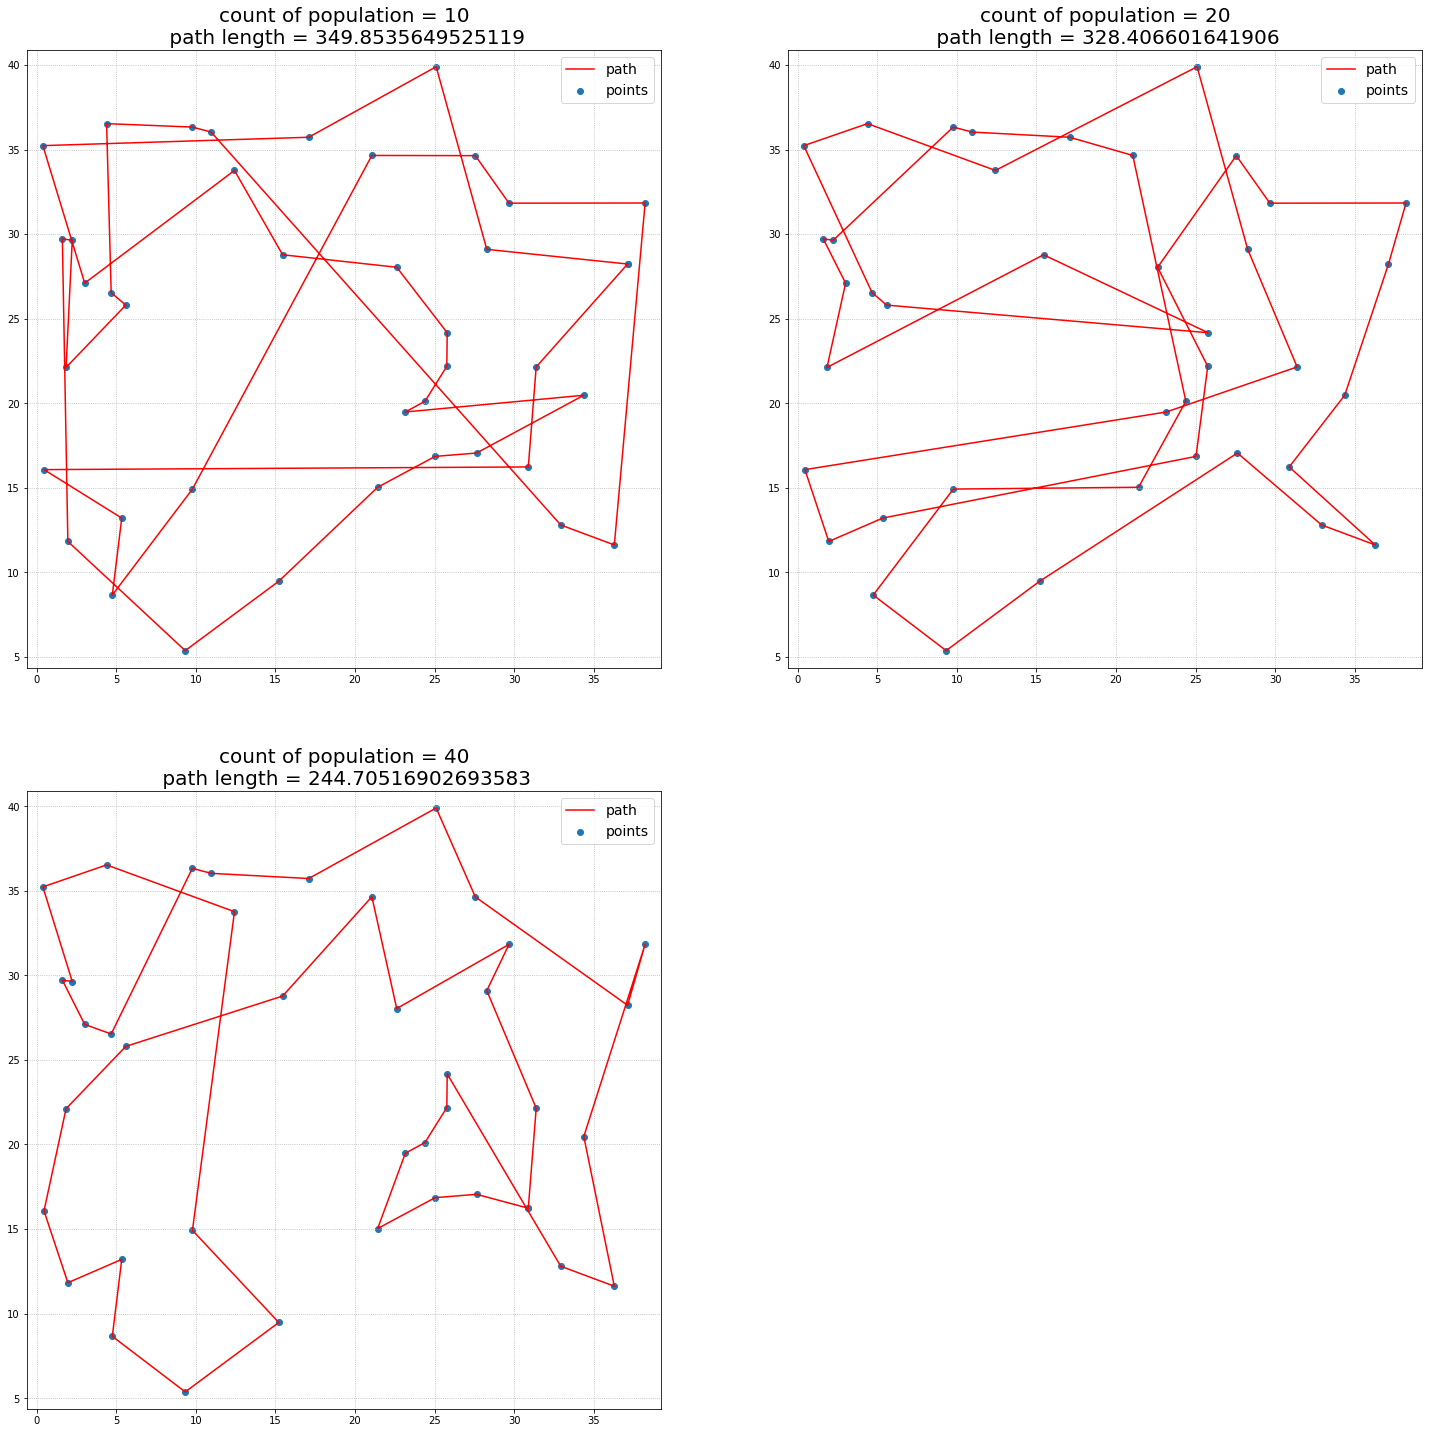

In [19]:

iter_count = 100 # количество итераций
popul_count = [10, 20, 40] #  размеры популяций


Graph = getRandomGraph(40) #рандомный граф размера 40

plt.figure(figsize=(25,25))

for i, p in enumerate(popul_count):
    indices = getCycleIndices(Genetic(Graph, iter_count, p))
    
    x = Graph[indices, 0]
    y = Graph[indices, 1]
    
    plt.subplot(2, 2, i+1)
    
    plt.title('count of population = {}\n path length = {}'\
              .format(p, pathLength(Graph, indices)), fontsize=20)
    plt.xlim((np.min(x)-1, np.max(x)+1))
    plt.ylim((np.min(y)-1, np.max(y)+1))
    
    plt.plot(x, y, color="r",label="path")
    plt.scatter(x,y, label="points")

    plt.grid(ls=":")
    plt.legend(fontsize=14)

plt.show()

Как мы можем видеть, при фиксированном числе итераций метода, чем больше элементов в популяции, тем лучше результат - с  увеличением размера мы все ближе подходим к оптимальному решению -  гамильтоновому циклу наименьшего веса. Но вместе с тем и растет время выполнения.

Теперь попробуем понаблюдать, какие результаты нам будут давать различные методы мутаций и методы скрещивания(при фиксированном размере популяции и кол-ве итераций).

Для этого мы возьмем реальные данные - а именно граф, описывающий 128 городов Северной Америки.

In [7]:
cities = np.genfromtxt("NorthAmerica_xy.txt")
print(cities.shape)

(128, 2)


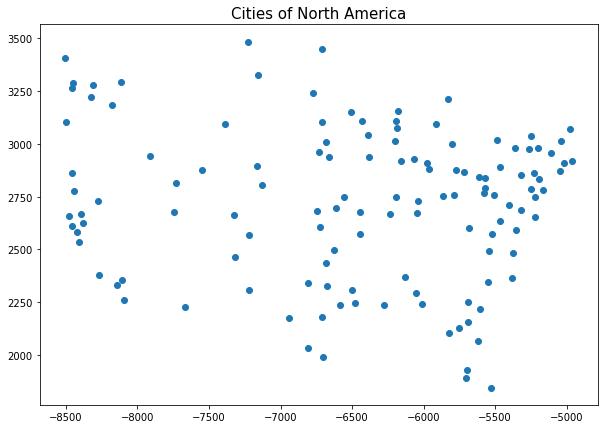

In [14]:
plt.figure(figsize=(10, 7))
plt.title("Cities of North America", fontsize=15)
plt.scatter(cities[:, 0],cities[:, 1], label="points")
plt.show()

100%|██████████| 400/400 [16:45<00:00,  2.85s/it]


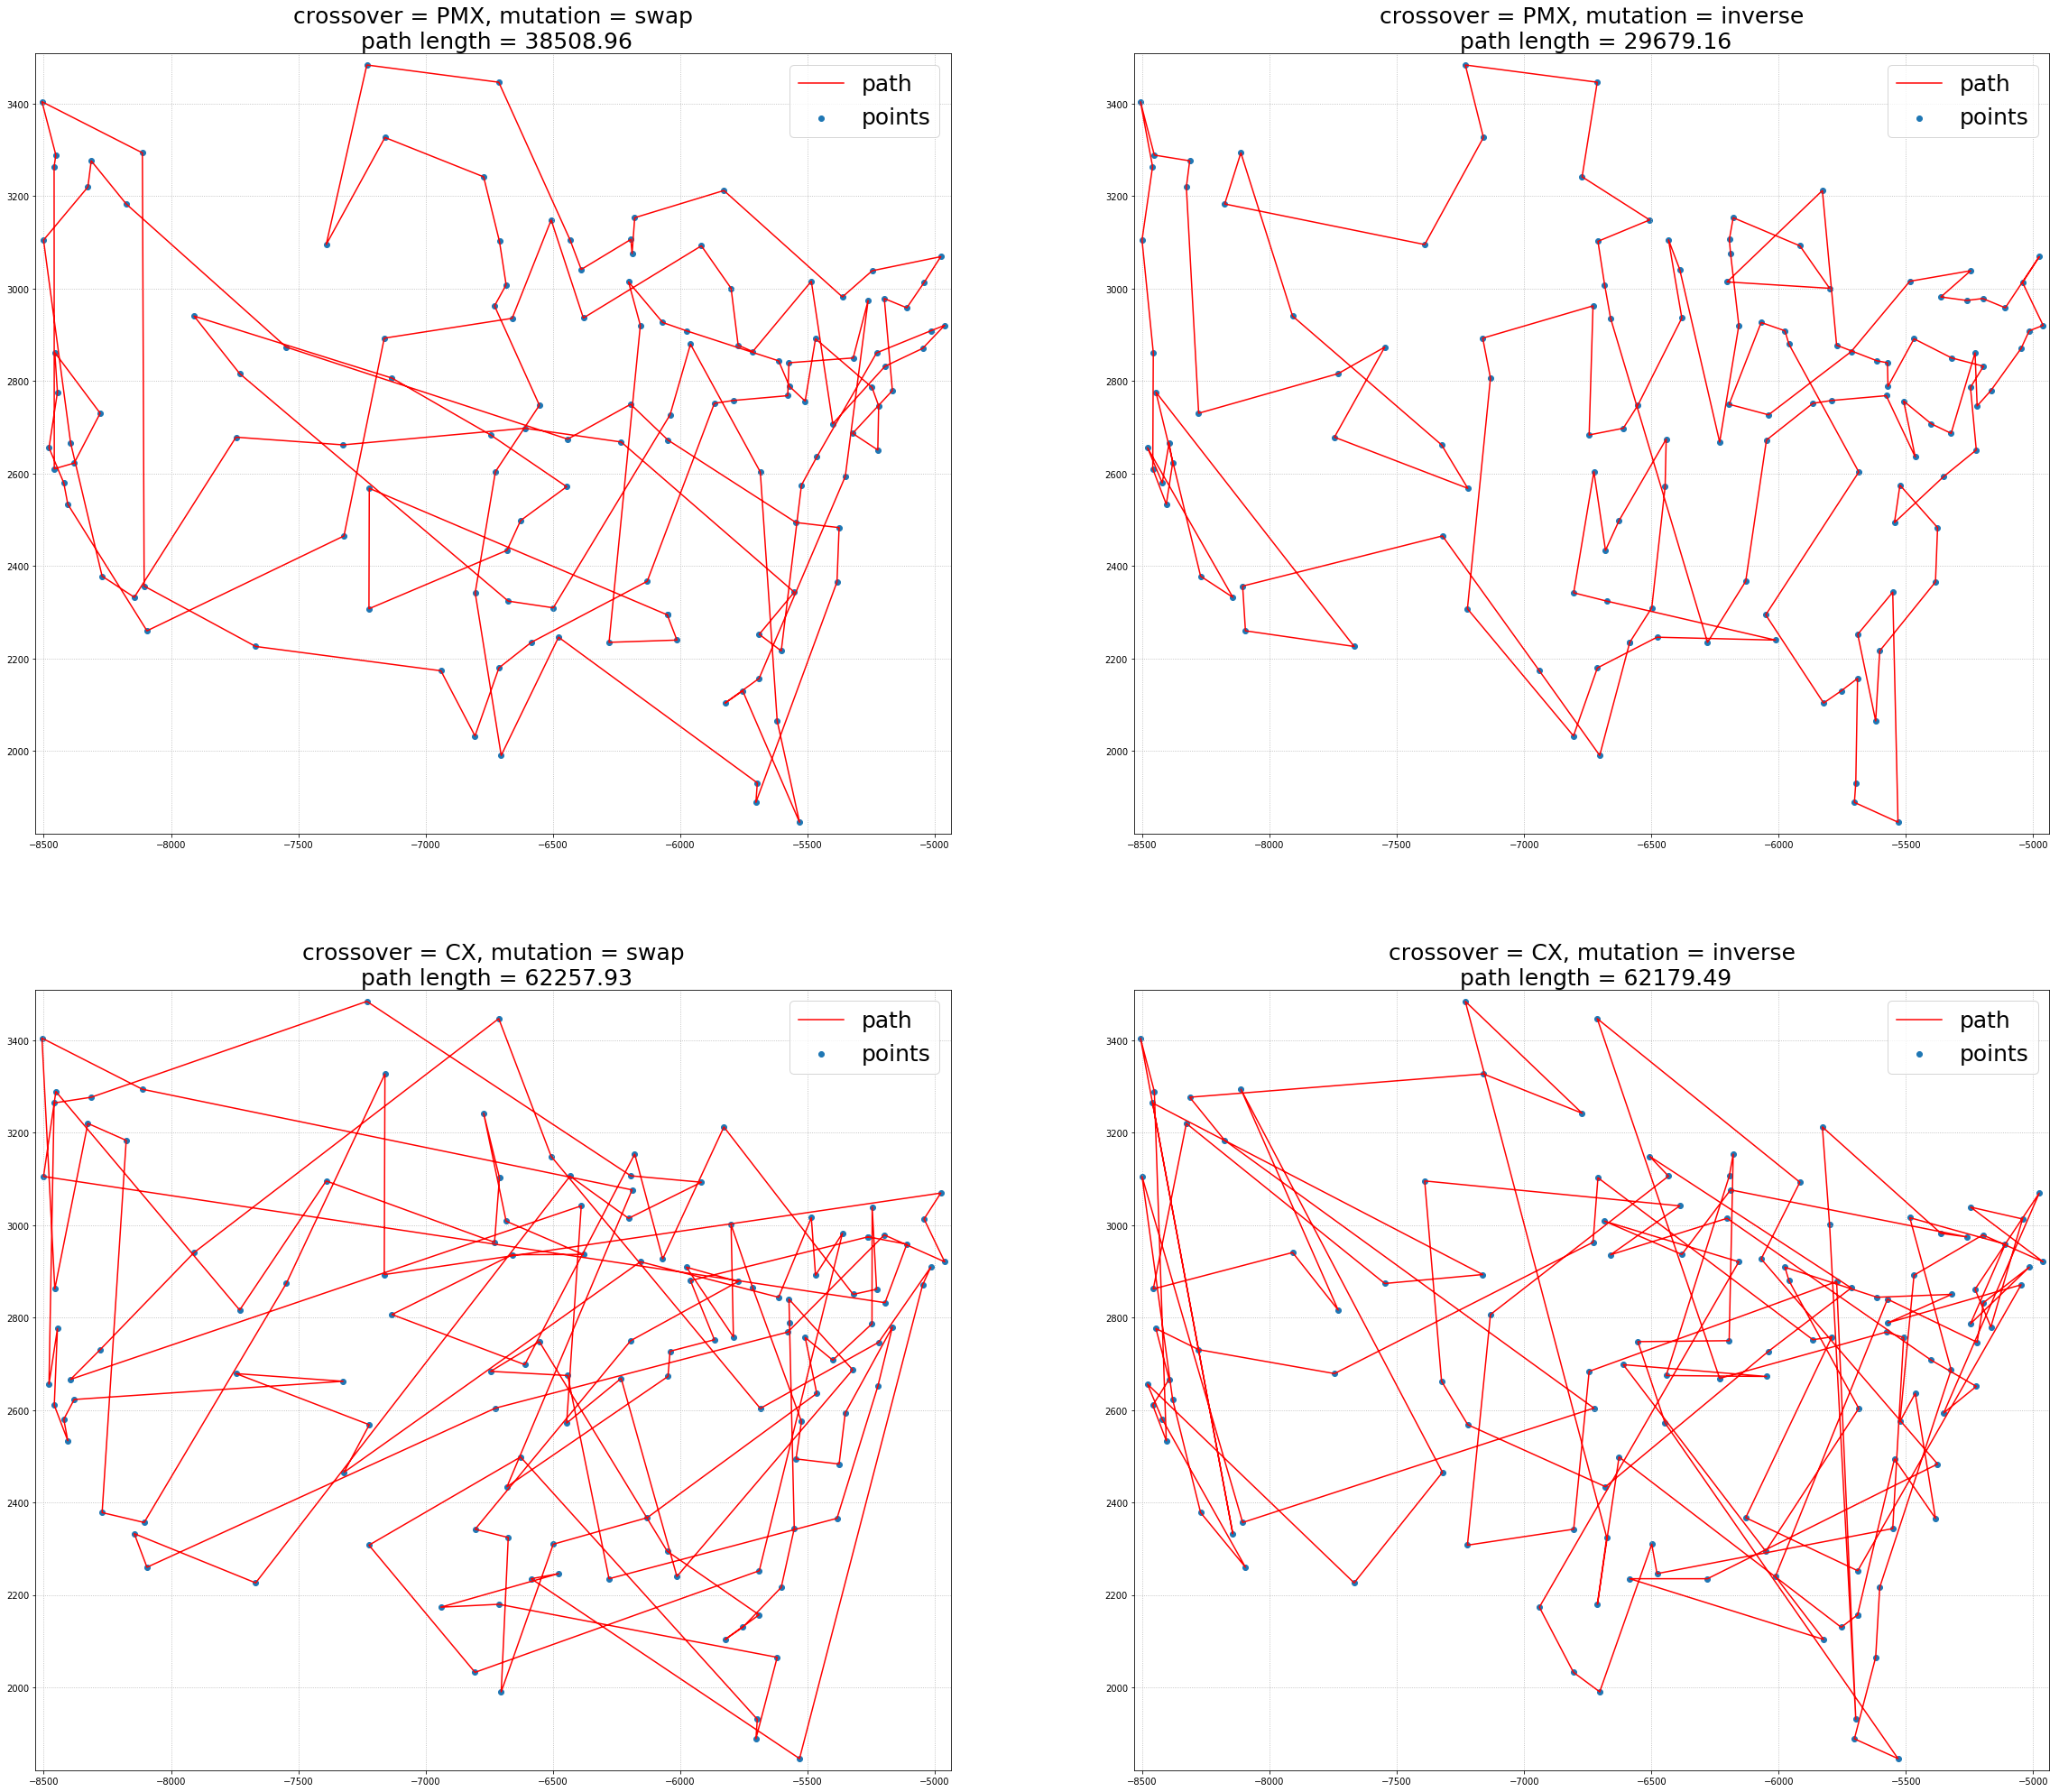

In [8]:
iter_count = 400 # количество итераций
popul_count = 35 # размер популяции

mutations = [swapMutate, invMutate]
cross = [PMX, CX]
M, C = np.meshgrid(mutations, cross)
M = np.ravel(M)
C = np.ravel(C)

mut_titles = ["swap", "inverse"]
cros_titles = ["PMX","CX"]
MT, CT = np.meshgrid(mut_titles, cros_titles)
MT = np.ravel(MT)
CT = np.ravel(CT)


plt.figure(figsize=(40, 35))

for i, (m, c, mt, ct) in enumerate(zip(M, C, MT, CT)):
    indices = getCycleIndices(Genetic(cities, iter_count, 
                                            popul_count,
                                       mutate_func=m,
                                       cross_func=c))
    
    x = cities[indices, 0]
    y = cities[indices, 1]
    
    plt.subplot(2, 2, i+1)
    plt.title("crossover = %s, mutation = %s\n path length = %.2f" \
          % (ct, mt, pathLength(cities, indices)), fontsize=25)
    plt.xlim((np.min(x)-25, np.max(x)+25))
    plt.ylim((np.min(y)-25, np.max(y)+25))
    plt.plot(x, y, color="r",label="path")
    plt.scatter(x,y, label="points")

    plt.grid(ls=":")
    plt.legend(fontsize=25)
    
plt.show()    

Как мы можем видеть, результаты показывают существенные раличия.

Алгоритм, использующий функцию мутации Inversion Mutation, и функцию скрещивания Partitially-Mapped Crossover выдает наилучшие результаты - длина пути $\approx 29679$. На втором месте идет реализация с мутацией Swap Mutation и тем же скрещиванием - путь $\approx 38508$, то есть хуже примерно на 30%.

Гораздо хуже сработали алгоритмы, использующие в качестве функции скрещивания Cycle Crossover. У обоих рализаций, вне зависимости от мутации (различие между ними оказалось несущественно), решение получилось почти в два раза хуже, чем у алогритмов, использующих PMX.

Видимо для таких данных не стоит брать в качестве скрещивания функцию CX. Хотя вполне возможно, что на каких нибудь других графах ситуация будет иной. 

Но, стоит отметить, что алгоритмы, использующие CX работали побыстрее, чем те, которые использовали PMX в качестве скрещивания.
***
Полагаю, тут нельзя быть до конца уверенным в эффективности тех или иных методов мутации и скрещивания для решения задачи в общем случае. Нужно на разных данных пробовать различные функции скрещивания и мутации, различные параметры алгоритма и смотреть, что из этого работает более эффективно для этих конкретных данных, находить компромисс между оптимальностью получающегося решения и временем работы.